## Linear Multivariate Gaussian State Space Model Benchmark

This use this simple benchmark in our README, but also to track the performance differences across new versions of Julia and the new version of the package (both ours and Turing).

In [1]:
import Pkg; Pkg.activate("."); Pkg.instantiate(); versioninfo() 

  Activating project at `~/.julia/dev/RxInfer.jl/benchmarks`


Julia Version 1.11.4
Commit 8561cc3d68d (2025-03-10 11:36 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin24.0.0)
  CPU: 11 × Apple M3 Pro
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, apple-m2)
Threads: 1 default, 0 interactive, 1 GC (on 5 virtual cores)


In [2]:
using RxInfer
using Random, Distributions
using BenchmarkTools, ColorSchemes, Colors, Plots, StableRNGs

# Some names clash, hence import
import Turing, ReverseDiff, Memoization
import CairoMakie

[ Info: Precompiling ForwardDiffExt [4b8ca102-9d0f-5df8-84ed-253e0f005ba7] (cache misses: wrong dep version loaded (10), incompatible header (4), mismatched flags (4))
[ Info: Precompiling DistributionsADLazyArraysExt [1640c15e-5bc7-5daf-855c-3cb1bdbdee06] 
[ Info: Precompiling BijectorsLazyArraysExt [bbe90f94-754b-5ce0-8e38-a167bbd0d2ed] 
[ Info: Precompiling TransducersBlockArraysExt [2edd95ec-771b-57d9-af99-689126140a09] (cache misses: wrong dep version loaded (8), incompatible header (2))
[ Info: Precompiling ReactiveMPOptimisersExt [63d19f3f-4d49-51b6-b357-07d893b7b5c8] (cache misses: wrong dep version loaded (10), incompatible header (6), mismatched flags (4))
[ Info: Precompiling TullioTrackerExt [51ca900b-941d-5297-8022-69c944a15689] 
[ Info: Precompiling DomainSetsMakieExt [da481366-01c8-5b4d-b359-47a10c8532e7] 


## State Estimation in a Linear Multivariate Gaussian State-space Model

In this demo, the goal is to smooth noisy observations by performing full inference with a state-space model (SSM).

We wil use the following model:

$$\begin{equation}
  \begin{aligned}
    \mathbf{x}_k & = \, \mathbf{A}\mathbf{x}_{k - 1} + \mathcal{P} \\
    \mathbf{y}_k & = \, \mathbf{B}\mathbf{x}_{k} + \mathcal{Q} \\
  \end{aligned}
\end{equation}$$
 
In this model, we denote by $\mathbf{x}_k$ the current state of the system (at time step $k$), by $\mathbf{x}_{k - 1}$ the previous state at time $k-1$, $\mathbf{A}$ and $\mathbf{B}$ are a constant system inputs and $\mathbf{y}_k$ is a noisy observation of $\mathbf{x}_k$. We further assume that the states and the observations are corrupted by i.i.d. Gaussian noise with variances $\mathcal{P}$ and $\mathcal{Q}$ respectively.

The SSM can be represented by the following factor graph, where the pictured section is chained over time:

<img src="pictures/ssm_model.png" alt="Gaussian Linear State Space Model" style="width: 400px;"/>

We can use the following code to create the model using the `RxInfer.jl` package interface with the `@model` macro:

In [3]:
# We create model using GraphPPL.jl package interface with @model macro
# For simplicity of the example we consider all matrices to be known and constant
@model function linear_gaussian_ssm_smoothing(y, A, B, P, Q)
    
    # Set a prior distribution for x[1]
    x[1] ~ MvNormal(μ = [ 0.0, 0.0 ], Σ = [ 100.0 0.0; 0.0 100.0 ]) 
    y[1] ~ MvNormal(μ = B * x[1], Σ = Q)
    
    for t in 2:length(y)
        x[t] ~ MvNormal(μ = A * x[t - 1], Σ = P)
        y[t] ~ MvNormal(μ = B * x[t], Σ = Q)    
    end

end

# It is also possible to create a single time step of the graph
# for filtering algorithm
@model function linear_gaussian_ssm_filtering(x_min_t_mean, x_min_t_cov, y_t, A, B, P, Q)    
    x_min_t ~ MvNormal(μ = x_min_t_mean, Σ = x_min_t_cov)
    x_t     ~ MvNormal(μ = A * x_min_t, Σ = P)
    y_t     ~ MvNormal(μ = B * x_t, Σ = Q)
end

In [4]:
function generate_data(n, A, B, P, Q; seed = 42)
    Random.seed!(seed)

    x_prev = zeros(2)
    x      = Vector{Vector{Float64}}(undef, n)
    y      = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        x[i]   = rand(MvNormal(A * x_prev, P))
        y[i]   = rand(MvNormal(B * x[i], Q))
        x_prev = x[i]
    end
   
    return x, y
end

generate_data (generic function with 1 method)

In [5]:
n = 200
θ = π / 15
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
B = [ 1.3 0.0; 0.0 0.7 ]
P = [ 0.05 0.0; 0.0 0.05 ]
Q = [ 10.0 0.0; 0.0 10.0 ]


real_x, real_y = generate_data(n, A, B, P, Q);

In [6]:
# Inference procedure for full graph
function rxinfer_inference_smoothing(observations, A, B, P, Q)
    n = length(observations) 
    
    result = infer(
        model = linear_gaussian_ssm_smoothing(A = A, B = B, P = P, Q = Q),
        data = (y = observations, ),
        options = (limit_stack_depth = 500, )
    )
    
    return result.posteriors[:x]
end

# Inference procedure for single time step graph and filtering
function rxinfer_inference_filtering(observations, A, B, P, Q)
    n = length(observations) 
    
    autoupdates = @autoupdates begin 
        x_min_t_mean, x_min_t_cov = mean_cov(q(x_t))
    end
    
    result = infer(
        model = linear_gaussian_ssm_filtering(A = A, B = B, P = P, Q = Q),
        data = (y_t = observations, ),
        autoupdates = autoupdates,
        initialization = @initialization(q(x_t) = MvNormalMeanCovariance([ 0.0, 0.0 ], [ 100.0 0.0; 0.0 100.0 ])),
        historyvars = (x_t = KeepLast(), ),
        keephistory = n
    )
    
    return result.history[:x_t]
end

rxinfer_inference_filtering (generic function with 1 method)

In [7]:
x_rxinfer_smoothing_inferred = rxinfer_inference_smoothing(real_y, A, B, P, Q);

In [8]:
x_rxinfer_filtering_inferred = rxinfer_inference_filtering(real_y, A, B, P, Q);

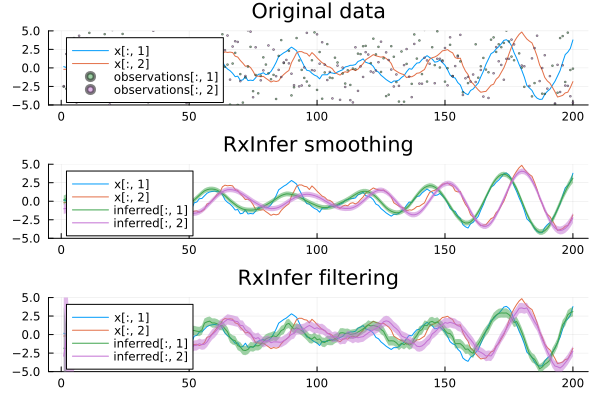

In [9]:
# Results verification

reshape_data(data) = transpose(reduce(hcat, data))

ylimit = (-5, 5)

generated_data = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
generated_data = plot!(1:n, real_y |> reshape_data, seriestype = :scatter, ms = 1, alpha = 0.5, label = [ "observations[:, 1]" "observations[:, 2]" ])
generated_data = plot!(generated_data, legend = :bottomleft, ylimit = ylimit, title = "Original data")

rmp_smoothing_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
rmp_smoothing_results_plot = plot!(rmp_smoothing_results_plot, 1:n, mean.(x_rxinfer_smoothing_inferred) |> reshape_data, ribbon = var.(x_rxinfer_smoothing_inferred) |> reshape_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
rmp_smoothing_results_plot = plot!(rmp_smoothing_results_plot, legend = :bottomleft, ylimit = ylimit, title = "RxInfer smoothing")

rmp_filtering_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
rmp_filtering_results_plot = plot!(rmp_filtering_results_plot, 1:n, mean.(x_rxinfer_filtering_inferred) |> reshape_data, ribbon = var.(x_rxinfer_filtering_inferred) |> reshape_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
rmp_filtering_results_plot = plot!(rmp_filtering_results_plot, legend = :bottomleft, ylimit = ylimit, title = "RxInfer filtering")

p = plot(generated_data, rmp_smoothing_results_plot, rmp_filtering_results_plot, layout = @layout([ a; b; c ]))
    
savefig(p, "./plots/inference_rxinfer.png")
savefig(p, "./plots/inference_rxinfer.svg")

p

In [10]:
benchmark_rmp_sizes = [ 50, 100, 250, 500, 1_000, 2_000, 5_000, 10_000, 15_000, 20_000, 25_000, 50_000 ];

In [11]:
rxinfer_benchmark_results = map(benchmark_rmp_sizes) do size
    # states, observations = generate_data(size, A, B, P, Q);
    
    benchmark_smoothing = @benchmark rxinfer_inference_smoothing(observations, $A, $B, $P, $Q) setup=begin
        states, observations = generate_data($size, $A, $B, $P, $Q);
    end
    
    benchmark_fitlering = @benchmark rxinfer_inference_filtering(observations, $A, $B, $P, $Q) setup=begin
        states, observations = generate_data($size, $A, $B, $P, $Q);
    end
    
    println(stdout, "Finished $size")
    flush(stdout)
    
    return (size, benchmark_smoothing, benchmark_fitlering)
end

Finished 50
Finished 100
Finished 250
Finished 500
Finished 1000
Finished 2000
Finished 5000
Finished 10000
Finished 15000
Finished 20000
Finished 25000
Finished 50000


12-element Vector{Tuple{Int64, BenchmarkTools.Trial, BenchmarkTools.Trial}}:
 (50, 3.627 ms, 439.625 μs)
 (100, 7.252 ms, 786.500 μs)
 (250, 19.558 ms, 1.795 ms)
 (500, 42.288 ms, 3.498 ms)
 (1000, 89.500 ms, 6.826 ms)
 (2000, 186.331 ms, 13.954 ms)
 (5000, 539.908 ms, 34.450 ms)
 (10000, 1.191 s, 70.240 ms)
 (15000, 2.172 s, 102.868 ms)
 (20000, 3.408 s, 138.604 ms)
 (25000, 3.780 s, 171.867 ms)
 (50000, 10.475 s, 344.902 ms)

In [12]:
benchmark_time_ms(trial) = mean(trial).time / 1_000_000

benchmark_time_ms (generic function with 1 method)

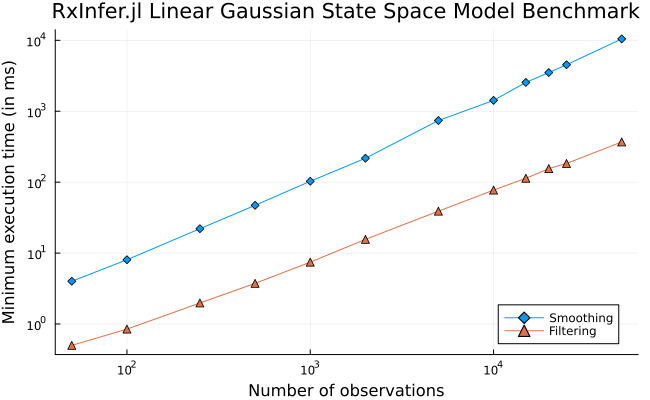

In [13]:
lgssm_scaling = plot(xscale = :log10, yscale = :log10, xlabel = "Number of observations", ylabel = "Minimum execution time (in ms)", title = "RxInfer.jl Linear Gaussian State Space Model Benchmark", legend = :bottomright, size = (650, 400))
lgssm_scaling = plot!(lgssm_scaling, benchmark_rmp_sizes, map(i -> benchmark_time_ms(rxinfer_benchmark_results[i][2]), 1:length(benchmark_rmp_sizes)), markershape = :diamond, label = "Smoothing")
lgssm_scaling = plot!(lgssm_scaling, benchmark_rmp_sizes, map(i -> benchmark_time_ms(rxinfer_benchmark_results[i][3]), 1:length(benchmark_rmp_sizes)), markershape = :utriangle, label = "Filtering")

display(lgssm_scaling)

# savefig(lgssm_scaling, "./plots/lgssm_scaling.svg")

In [14]:
Turing.@model LinearGaussianSSM(y, A, B, P, Q, ::Type{TV} = Vector{Vector{Float64}}) where TV = begin
    n = length(y)

    # State sequence.
    x = map(s -> zeros(2), 1:n)

    # Observe each point of the input.
    x[1] ~ MvNormal([ 0.0, 0.0 ], 1e1)
    y[1] ~ MvNormal(B * x[1], Q)

    for t in 2:n
        x[t] ~ MvNormal(A * x[t - 1], P)
        y[t] ~ MvNormal(B * x[t], Q)
    end
end;

In [15]:
function turing_inference_smoothing(observations, A, B, P, Q; nsamples = 500, method = Turing.HMC(0.05, 10; adtype = Turing.AutoReverseDiff(true)), seed = 42)
    return Turing.sample(StableRNG(seed), LinearGaussianSSM(observations, A, B, P, Q), method, nsamples)
end

turing_inference_smoothing (generic function with 1 method)

In [16]:
x_turing_500_smoothing_inferred  = turing_inference_smoothing(real_y, A, B, P, Q, nsamples = 500);
x_turing_1000_smoothing_inferred = turing_inference_smoothing(real_y, A, B, P, Q, nsamples = 1000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


In [ ]:
samples_500  = get(x_turing_500_smoothing_inferred, :x);
samples_1000 = get(x_turing_1000_smoothing_inferred, :x);

mx_500 = [ mean(samples_500.x[i].data) for i in 1:2n ]
vx_500 = [ std(samples_500.x[i].data)  for i in 1:2n ];

mx_1000 = [ mean(samples_1000.x[i].data) for i in 1:2n ]
vx_1000 = [ std(samples_1000.x[i].data)  for i in 1:2n ];

In [ ]:
reshape_turing_data(data) = transpose(reshape(data, (2, Int(length(data) / 2))))

In [ ]:
generated_data = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
generated_data = plot!(1:n, real_y |> reshape_data, seriestype = :scatter, ms = 1, alpha = 0.5, label = [ "observations[:, 1]" "observations[:, 2]" ])
generated_data = plot!(generated_data, legend = :bottomleft, ylimit = ylimit, title = "Original data")

turing_500_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
turing_500_results_plot = plot!(turing_500_results_plot, 1:n, mx_500 |> reshape_turing_data, ribbon = vx_500 |> reshape_turing_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
turing_500_results_plot = plot!(turing_500_results_plot, legend = :bottomleft, ylimit = ylimit, title = "HMC (0.05, 10.0, 500)")

turing_1000_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
turing_1000_results_plot = plot!(turing_1000_results_plot, 1:n, mx_1000 |> reshape_turing_data, ribbon = vx_1000 |> reshape_turing_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
turing_1000_results_plot = plot!(turing_1000_results_plot, legend = :bottomleft, ylimit = ylimit, title = "HMC (0.05, 10.0, 1000)")

p = plot(generated_data, turing_500_results_plot, turing_1000_results_plot, layout = @layout([ a; b; c ]))
    
savefig(p, "./plots/inference_turing.png")
savefig(p, "./plots/inference_turing.svg")

p

# Benchmark 1000

In [ ]:
real_x_1000, real_y_1000 = generate_data(1000, A, B, P, Q);

In [ ]:
turing_500_n_1000_benchmark  = @benchmark turing_inference_smoothing($real_y_1000, $A, $B, $P, $Q, nsamples = 500);
turing_1000_n_1000_benchmark = @benchmark turing_inference_smoothing($real_y_1000, $A, $B, $P, $Q, nsamples = 1000);

In [ ]:
rxinfer_filtering_n_1000_benchmark = @benchmark rxinfer_inference_filtering($real_y_1000, $A, $B, $P, $Q);
rxinfer_smoothing_n_1000_benchmark = @benchmark rxinfer_inference_smoothing($real_y_1000, $A, $B, $P, $Q);

# Plotting

In [ ]:
c = palette(:rainbow)

c1 = get(ColorSchemes.rainbow, 0.5) ; 
c2 = get(ColorSchemes.rainbow, 0.9) ; 
c3 = get(ColorSchemes.rainbow, 0.3) ; 
c4 = get(ColorSchemes.rainbow, 0.8) ; 
c5 = get(ColorSchemes.rainbow, 0.9) ;

colors = [ c1, c2, c3, c4 ];

In [ ]:
comparison_fig = begin
    
    # Local vars
    local bar_names  = [ "RxInfer Filtering", "RxInfer Smoothing", "Turing HMC(500)", "Turing HMC(1000)" ]
    local bar_values = [
        benchmark_time_ms(rxinfer_filtering_n_1000_benchmark),
        benchmark_time_ms(rxinfer_smoothing_n_1000_benchmark),
        benchmark_time_ms(turing_500_n_1000_benchmark),
        benchmark_time_ms(turing_1000_n_1000_benchmark)
    ] 
    
    
    local range = 1:length(bar_names)
    
    # Figure
    
    local fig = CairoMakie.Figure(size = (650, 500), backgroundcolor = :transparent)

    # Axis
    
    local ax  = CairoMakie.Axis(fig, backgroundcolor = :transparent)
    ax.ylabel = "Inference time (log scale, in ms)"
    ax.title  = "Linear Gaussian State Space Model for 1000 observations"
    ax.yscale = CairoMakie.Makie.pseudolog10
    ax.yticks = ([ 1, 10, 100, 1000, 10_000, 50_000 ], [ "1", "10", "1e2", "1e3", "1e4", "5e4" ])
    ax.xticklabelrotation = -π / 16
    # ax.xticklabelalign = (0.5, 1.5)
    
    ax.xticks = (range, bar_names)
    ax.xticklabelsize = 14
    
    # Barplot 1
    
    local bp = CairoMakie.barplot!(ax, range, bar_values, color = colors)
    
    bp.strokewidth = 1
    # bp.color    = colors
    bp.colormap = (:Accent_4, 0.9)
    bp.strokecolor = :black
    bp.x_gap = 0.12
    
    
    local text_values = map(bar_values) do value
        return string(round(value, digits = 2), " ms")
    end
    
    text_values[2] = string(text_values[2], "\n", string("ratio = ", Int(round(bar_values[2] / bar_values[2])), "\n(baseline)"))
    text_values[3] = string(text_values[3], "\n\n", string("ratio = ", Int(round(bar_values[3] / bar_values[2])), ""))
    text_values[4] = string(text_values[4], "\n\n", string("ratio = ", Int(round(bar_values[4] / bar_values[2])), ""))
    
    local tx = CairoMakie.text!(text_values, position = CairoMakie.Point.(range, bar_values .+ [ 1.55, 0.25, 0, 0 ]))
    
    tx.align  = (:center, :center)
    tx.offset = (0, -30)
    # tx.color  = [ :black, :black, :black, :black ]
    tx.textsize = 13
    
    # Layout

    fig[1, 1] = ax
    
    # Return 
    
    CairoMakie.save("./plots/lgssm_comparison.svg", fig)
    CairoMakie.save("./plots/lgssm_comparison.png", fig)
    
    fig
end

In [ ]:
scaling_fig = begin 
    local fig = CairoMakie.Figure(size = (650, 500), backgroundcolor = :transparent)
    
    local ax = CairoMakie.Axis(fig[1, 1], backgroundcolor = :transparent)
    
    ax.title = "RxInfer.jl Linear Gaussian State Space Model Scalability"
    
    ax.xlabel = "Number of observations (log scale)"
    ax.xscale = CairoMakie.Makie.pseudolog10
    ax.xticks = (
        [ 50, 100, 250, 500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000 ], 
        [ "50", "100", "250", "500", "1e3", "2e3", "5e3", "1e4", "2e4", "5e4" ]
    )
    
    ax.ylabel = "Minimum execution time (log scale, in ms)"
    ax.yscale = CairoMakie.Makie.pseudolog10
    ax.yticks = (
        [ 1, 10, 100, 1_000, 10_000, 50_000 ], 
        [ "1", "10", "100", "1e3", "1e4", "5e4" ]
    )
    
    local range = benchmark_rmp_sizes
    local smoothing = map(i -> benchmark_time_ms(rxinfer_benchmark_results[i][2]), 1:length(benchmark_rmp_sizes))
    local filtering = map(i -> benchmark_time_ms(rxinfer_benchmark_results[i][3]), 1:length(benchmark_rmp_sizes))
    
    CairoMakie.lines!(ax, range, smoothing)
    CairoMakie.scatter!(ax, range, smoothing, marker = :diamond, markersize = 15, label = "Smoothing")
    
    CairoMakie.lines!(ax, range, filtering)
    CairoMakie.scatter!(ax, range, filtering, marker = :circle, markersize = 15, label = "Filtering")
    
    CairoMakie.axislegend(position = :rb)
    
    CairoMakie.save("./plots/lgssm_scaling.svg", fig)
    CairoMakie.save("./plots/lgssm_scaling.png", fig)
    
    fig
end